# Better Implementation of Steane T state preperation and MSD

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction

In [29]:
steane_enc_block = QuantumCircuit(7, 7, name="steane_block")
for i in range(1, 3):
    steane_enc_block.h(i)

steane_enc_block.h(6)
steane_enc_block.t(6)
steane_enc_block.barrier()

steane_enc_block.cx(1, 0)
steane_enc_block.cx(2, 4)
steane_enc_block.cx(6, 5)

steane_enc_block.cx(2,0)
steane_enc_block.cx(3,5)

steane_enc_block.cx(6,4)
steane_enc_block.cx(2,6)

steane_enc_block.cx(3,4)

steane_enc_block.cx(1,5)
steane_enc_block.cx(1,6)

steane_enc_block.cx(3 ,0)

steane_enc_block.barrier()

for i in range(0, 7):
    steane_enc_block.h(i)
    #steane_enc_block.measure(i,i)
steane_enc_block.barrier()

# convert to instruction
steane_block_instr = steane_enc_block.to_instruction()

H to all 7 qubits

In [16]:
# applies h to 7 qubits 

h_block = QuantumCircuit(7, 7, name="h_block")
for i in range(0, 7):
    h_block.h(i)

# convert to instruction
h_block_instr = h_block.to_instruction()


CZ to all 7 qubits

In [17]:
# applies cz to 7 qubits

cz_block = QuantumCircuit(14, 14, name="cz_block")
for i in range(0, 7):
    cz_block.cz(i, i + 7)


# convert to instruction
cz_block_instr = cz_block.to_instruction()

Identity to all 7 qubits

In [18]:
# applies identity to 7 qubits

id_block = QuantumCircuit(7,7, name = "id_block")

for i in range(0, 7):
    id_block.id(i)

id_block_instr = id_block.to_instruction()

In [30]:
def prepare_t(qc_prep: QuantumCircuit, block_instr: Instruction):
    qc_prep.append(id_block_instr, range(0,7), range(0,7))
    qc_prep.append(block_instr, range(0,7), range(0,7))
    qc_prep.append(id_block_instr, range(0,7), range(0,7))

In [ ]:


# state_arr will hold the 3 T states we get from the Steane encoding
state_arr = []

qc1 = QuantumCircuit(7,7)
qc2 = QuantumCircuit(7,7)
qc3 = QuantumCircuit(7,7)

qc_arr = [qc1, qc2, qc3]





for i in range(0,3): 
    prepare_t(qc_arr[i], steane_block_instr)
    simulator = Aer.get_backend('statevector_simulator')
    steane_t = transpile(qc_arr[i], simulator)
    job = simulator.run(steane_t, shots = 1024)
    result = job.result()
    counts = result.get_counts()
    state = result.get_statevector()
    state_arr.append(state)


plot_histogram(counts)


print(state_arr)
    



[Statevector([ 2.13388348e-01+8.83883476e-02j,
             -1.02796299e-18+2.13098137e-17j,
             -1.13797963e-17+1.82361881e-17j,
             -1.67519718e-17+3.46944695e-18j,
             -1.67519718e-17+3.46944695e-18j,
             -1.13797963e-17+1.82361881e-17j,
             -1.02796299e-18+2.13098137e-17j,
              2.13388348e-01+8.83883476e-02j,
              2.13388348e-01+8.83883476e-02j,
             -1.02796299e-18+2.13098137e-17j,
             -1.13797963e-17+1.82361881e-17j,
             -1.67519718e-17+3.46944695e-18j,
             -1.67519718e-17+3.46944695e-18j,
             -1.13797963e-17+1.82361881e-17j,
             -1.02796299e-18+2.13098137e-17j,
              2.13388348e-01+8.83883476e-02j,
              5.08088743e-19+1.96261557e-17j,
              1.15391880e-17+1.01146505e-17j,
             -6.32069830e-18+1.38777878e-17j,
              3.66116524e-02-8.83883476e-02j,
              3.66116524e-02-8.83883476e-02j,
             -6.32069830e-18+1.38

currently something is wrong with these results

In [32]:
def append_converted_block(qc_in: QuantumCircuit, block_instr: Instruction):
    for i in range(0,3):
        qc_in.append(block_instr, range(7*i , 7*i + 7 ), range(7*i , 7*i + 7 ))


c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


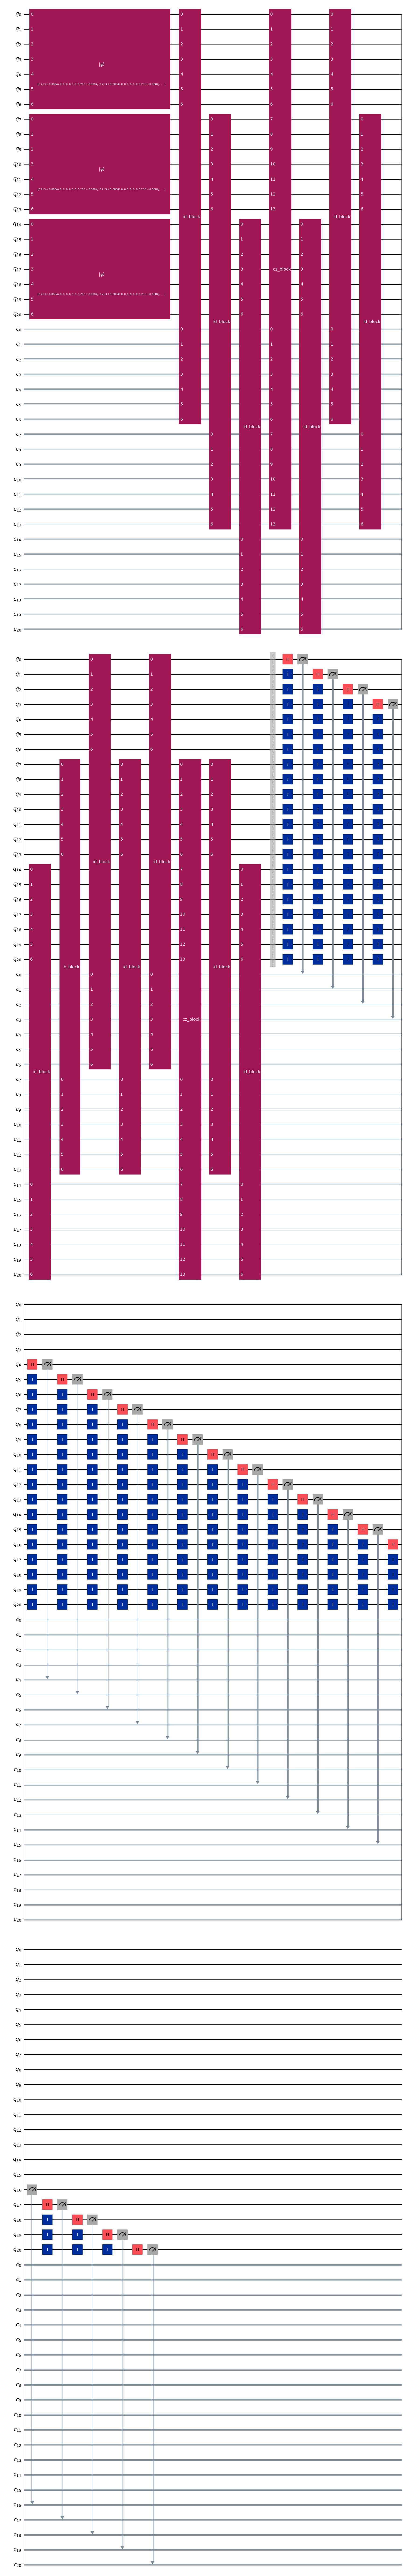

In [33]:
qc_3_713 = QuantumCircuit(21,21)

# initalize MSD circuit with results of Steane T state prep
for i in range(0,3):
    qc_3_713.initialize(state_arr[i], range( 7*i , 7*i + 7 ))

append_converted_block(qc_3_713, id_block_instr)

qc_3_713.append(cz_block_instr, range(0,14), range(0,14))

append_converted_block(qc_3_713, id_block_instr)

qc_3_713.append(h_block_instr, range(7,14), range(7,14))

append_converted_block(qc_3_713, id_block_instr)

qc_3_713.append(cz_block_instr, range(7,21), range(7,21))

append_converted_block(qc_3_713, id_block_instr)
# qc_3_713.append(measure_block_instr, range(0,21), range(0,21))

qc_3_713.barrier()

for i in range(0, 21):
    qc_3_713.h(i)
    if i < 21:
        for k in range(i + 1, 21):
            qc_3_713.id(k)
    qc_3_713.measure(i, i)



qc_3_713.draw('mpl')

In [ ]:
# Transpile for simulator backend
simulator = Aer.get_backend('qasm_simulator')

steane_t = transpile(qc_3_713, simulator)

In [ ]:

# sampler = Sampler()
job = simulator.run(steane_t, shots = 10)

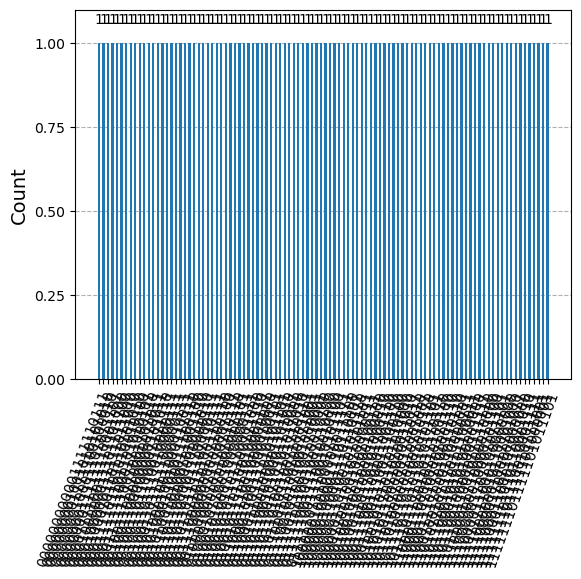

In [36]:
result = job.result()

# Get counts and plot
counts = result.get_counts()
plot_histogram(counts)


Add noise

In [ ]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])

In [ ]:

noisy_simulator = AerSimulator(noise_model=noise_model)

steane_t = transpile(qc_3_713, noisy_simulator)

noisy_sampler = BackendSampler(backend=noise_model)
job = simulator.run(steane_t, shots = 1024)


result = job.result()

# Get counts and plot
counts = result.get_counts()
plot_histogram(counts)